In [1]:
import sys, os, multiprocessing
import h3ronpy, h3

import pandas as pd
import geopandas as gpd


from tqdm.notebook import tqdm
from h3ronpy.pandas.vector import geodataframe_to_cells, cells_dataframe_to_geodataframe
from h3ronpy import ContainmentMode

from GOSTrocks.misc import tPrint

In [2]:
base_folder = r"C:\WBG\Work\S2S"
admin_folder = os.path.join(base_folder, "data", 'admin')
out_folder = os.path.join(base_folder, "ADM_RESULTS")

if not os.path.exists(out_folder):
    os.makedirs(out_folder)

# Get the admin boundaries
admin_file = r"C:\WBG\Work\data\ADMIN\NEW_WB_BOUNDS\WB_GAD_ADM2.shp"
in_admin = gpd.read_file(admin_file)
in_admin['gID'] = list(range(1, in_admin.shape[0] + 1))
in_admin['gID'] = in_admin.apply(lambda x: f'{x["WB_A3"]}_{x["gID"]}', axis=1)
in_admin.head()

,ISO_A3,ISO_A2,WB_A3,HASC_0,HASC_1,HASC_2,GAUL_0,GAUL_1,GAUL_2,WB_REGION,...,ADM2CD_t,ADM2NM,GEOM_SRCE,P_DATE,SALB_DATE,Layer,Shape_Leng,Shape_Area,geometry,gID
0,CHN,CN,CHN,CN,CN.HL,None,147295,908,13088,EAP,...,CHN011007,None,WB GAD,2020-09-10,None,2,12.686519,2.607028,"POLYGON ((133.89558 46.55695, 133.89555 46.545...",CHN_1
1,CHN,CN,CHN,CN,CN.HL,None,147295,908,13089,EAP,...,CHN011004,None,WB GAD,2020-09-10,None,2,8.400738,1.700403,"POLYGON ((132.52369 47.71289, 132.51065 47.683...",CHN_2
2,CHN,CN,CHN,CN,CN.HL,None,147295,908,13090,EAP,...,CHN011011,None,WB GAD,2020-09-10,None,2,10.767553,2.611398,"POLYGON ((133.89558 46.55695, 133.89177 46.549...",CHN_3
3,CHN,CN,CHN,CN,CN.HL,None,147295,908,13092,EAP,...,CHN011013,None,WB GAD,2020-09-10,None,2,13.542786,3.857735,"POLYGON ((130.81428 48.33685, 130.72977 48.307...",CHN_4
4,CHN,CN,CHN,CN,CN.HL,None,147295,908,13093,EAP,...,CHN011006,None,WB GAD,2020-09-10,None,2,16.951572,3.753208,"POLYGON ((129.92461 47.29074, 129.97993 47.268...",CHN_5


In [3]:
def run_country_mp(cntry_label, in_data, out_folder):
    """ Iterate through the country and get intersecting hex_ids for each feature in in_data

    Parameters
    ----------
    cntry_label : string
        The country label to use for the output
    in_data : geopandas.GeoDataFrame
        The input data to process of admini features
    """    
    out_file = os.path.join(out_folder, f'{cntry_label}_h3_intersect.csv')
    if not os.path.exists(out_file):    
        all_res = []
        for idx, row in tqdm(in_data.iterrows(), total=in_data.shape[0], desc=f'Processing {cntry_label}'):
            in_shape = gpd.GeoDataFrame(row.to_frame().T, geometry="geometry", crs=in_data.crs)
            in_shape['geometry'] = in_shape['geometry'].apply(lambda x: x.buffer(0))                                        
            cur_res = get_bounds(in_shape, 6)
            cur_res['cntry'] = cntry_label
            all_res.append(cur_res)
        
        country_res = pd.concat(all_res, ignore_index=True)
        country_res.to_csv(out_file, index=False)
    else:
        country_res = pd.read_csv(out_file)
    return(country_res)


def get_bounds(in_shp, h3_lvl=6):
    """ Generate a geodataframe for the supplied in_shp with the H3 cells and % overlap

    Parameters
    ----------
    in_shp : shapely.geometry.polygon.Polygon
        The input shapely polygon
    h3_lvl : int
        The H3 level to use for the hexagons, default is 6
    """
    # extract the H3 cells
    cols_to_keep = ['gID', 'cell', 'overlap']
    cell_ax = cells_dataframe_to_geodataframe(geodataframe_to_cells(in_shp, 6, ContainmentMode.IntersectsBoundary))
    cell_ax['cell'] = cell_ax['cell'].apply(lambda x: hex(x)[2:])    
    # Identify contained and overlapping hexes with the admin bounds
    contained_h3 = cell_ax.sjoin(in_shp, predicate='within')
    missed_h3 = cell_ax[~cell_ax['cell'].isin(contained_h3['cell'])]
    # calculate h3x overlap with feature
    shp_area = in_shp.union_all()
    cell_ax['overlap'] = 0.0
    cell_ax.loc[contained_h3.index, 'overlap'] = 1.0
    cell_ax.loc[missed_h3.index, 'overlap'] = cell_ax.loc[missed_h3.index,'geometry'].apply(lambda x: x.intersection(shp_area).area/x.area)\
    
    return cell_ax.loc[:, cols_to_keep].reset_index(drop=True)
'''
sel_admin = in_admin.loc[in_admin['WB_A3'] == 'KEN']
xx = get_bounds(gpd.GeoDataFrame(sel_admin.iloc[0].to_frame().T, geometry="geometry", crs=sel_admin.crs), 6)
xx.head(10)
'''


'\nsel_admin = in_admin.loc[in_admin[\'WB_A3\'] == \'KEN\']\nxx = get_bounds(gpd.GeoDataFrame(sel_admin.iloc[0].to_frame().T, geometry="geometry", crs=sel_admin.crs), 6)\nxx.head(10)\n'

In [4]:
mp_args = []
for cntry, data in in_admin.groupby('WB_A3'):
    mp_args.append([cntry, data, out_folder])

run_country_mp(*mp_args[0])

,gID,cell,overlap,cntry
0,ABW_26522,866773607ffffff,0.969437,ABW
1,ABW_26522,86677360fffffff,0.480238,ABW
2,ABW_26522,866773617ffffff,0.259170,ABW
3,ABW_26522,86677361fffffff,0.002262,ABW
4,ABW_26522,866773627ffffff,0.397704,ABW
5,ABW_26522,86677362fffffff,0.503282,ABW
6,ABW_26522,866773637ffffff,1.000000,ABW
7,ABW_26522,866773657ffffff,0.001197,ABW
8,ABW_26522,866773677ffffff,0.157010,ABW
9,ABW_26522,86677371fffffff,0.072922,ABW


In [5]:
for cntry, data, outFolder in tqdm(mp_args):
    print(f'Processing {cntry}')
    if not cntry in ['FJI','RUS']: #['CAN', 'RUS', 'USA', 'FJI']:
        res = run_country_mp(cntry, data, outFolder)

  0%|          | 0/237 [00:00<?, ?it/s]

Processing ABW
Processing ADO
Processing AFG
Processing AGO
Processing AIA
Processing ALB
Processing ARE
Processing ARG
Processing ARM
Processing ASM
Processing ATF
Processing ATG
Processing AUS
Processing AUT
Processing AZE
Processing BDI
Processing BEL
Processing BEN
Processing BES
Processing BFA
Processing BGD
Processing BGR
Processing BHR
Processing BHS
Processing BIH
Processing BLM
Processing BLR
Processing BLZ
Processing BMU
Processing BOL
Processing BRA
Processing BRB
Processing BRN
Processing BTN
Processing BVT
Processing BWA
Processing CAF
Processing CAN
Processing CCK
Processing CHE
Processing CHL
Processing CHN
Processing CIV
Processing CMR
Processing COG
Processing COK
Processing COL
Processing COM
Processing CPV
Processing CRI
Processing CUB
Processing CUW
Processing CXR
Processing CYM
Processing CYP
Processing CZE
Processing DEU
Processing DJI
Processing DMA
Processing DNK
Processing DOM
Processing DRC
Processing DZA
Processing ECU
Processing EGY
Processing ERI
Processing

# DEBNRURGGIGN

<Axes: >

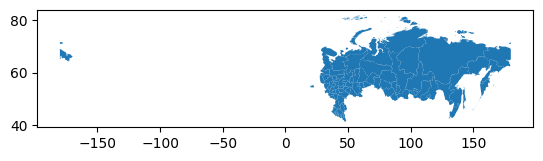

In [6]:
cntry_label = 'RUS'
in_data = in_admin.loc[in_admin['WB_A3'] == cntry_label]
in_data.plot()

In [8]:
in_data.to_file(os.path.join(out_folder, f'{cntry_label}_h3_intersect.gpkg'), driver='GPKG')

In [7]:
all_res = []
for idx, row in in_data.iterrows():
    tPrint(idx)
    in_shape = gpd.GeoDataFrame(row.to_frame().T, geometry="geometry", crs=in_data.crs)
    in_shape['geometry'] = in_shape['geometry'].apply(lambda x: x.buffer(0))                                        
    cur_res = get_bounds(in_shape, 6)
    cur_res['cntry'] = cntry_label
    all_res.append(cur_res)

10:20:05	1640
10:20:05	1641
10:20:06	1642
10:20:06	1643
10:20:06	1644
10:20:06	3022
10:20:08	3023
10:20:08	3024
10:20:23	3458
10:20:23	3459
10:20:24	3460
10:20:24	3461
10:20:24	3462
10:20:25	3463
10:20:25	3464
10:20:26	3914
10:20:30	3915
10:20:30	3916
10:20:30	3917
10:20:30	3918
10:20:31	3919
10:20:31	4742
10:20:31	4743
10:20:31	4744
10:20:31	4745
10:20:32	4746
10:20:32	4747
10:20:32	4748
10:20:35	5038
10:20:35	5039
10:20:35	5040
10:20:35	5041
10:20:35	5042
10:20:35	5398
10:20:35	5399
10:20:35	5400
10:20:35	5401
10:20:36	5402
10:20:36	5403
10:20:36	5404
10:20:36	5405
10:20:36	5406
10:20:36	5407
10:20:36	5408
10:20:36	5409
10:20:36	5410
10:20:36	5411
10:20:36	5412
10:20:36	5413
10:20:36	5414
10:20:36	5415
10:20:36	5416
10:20:36	5417
10:20:37	5418
10:20:37	5419
10:20:37	5420
10:20:37	5421
10:20:37	5422
10:20:37	5423
10:20:37	5424
10:20:41	5425
10:20:41	5426
10:20:41	5427
10:20:41	5428
10:20:41	5429
10:20:41	5430
10:20:41	5431
10:20:41	5432
10:20:41	5433
10:20:41	5434
10:20:41	5435
10:20:

GEOSException: TopologyException: side location conflict at 179.86436254237722 71.004671325745363. This can occur if the input geometry is invalid.

In [9]:
row

ISO_A3                                                      RUS
ISO_A2                                                       RU
WB_A3                                                       RUS
HASC_0                                                       RU
HASC_1                                                    RU.CK
HASC_2                                                     None
GAUL_0                                                      204
GAUL_1                                                     2501
GAUL_2                                                    25042
WB_REGION                                                   ECA
WB_STATUS                                          Member State
SOVEREIGN                                                   RUS
NAM_0                                        Russian Federation
NAM_1                                          Chukotskiy Okrug
NAM_1_GAUL                                     Chukotskiy Okrug
NAM_1_STAT                              

In [14]:
row.geometry.bounds

(-179.99999999999997, 61.80834390748955, 180.0000000000001, 71.60615010000004)

In [ ]:
sel_row = in_data.loc[24588]
in_shp = gpd.GeoDataFrame(sel_row.to_frame().T, geometry="geometry", crs=in_data.crs)
            

In [ ]:
~contained_h3['cell'].isin(cell_ax['cell'])

In [ ]:
cell_ax

In [ ]:
cell_ax.to_file(os.path.join(out_folder, f'{cntry_label}_h3_intersect.gpkg'), driver='GPKG')

In [ ]:
tPrint('Starting')
cols_to_keep = ['gID', 'cell', 'overlap']
cell_ax = cells_dataframe_to_geodataframe(geodataframe_to_cells(in_shp, 6, ContainmentMode.IntersectsBoundary))
cell_ax['cell'] = cell_ax['cell'].apply(lambda x: hex(x)[2:])
tPrint("Generated H3 cells")
shp_area = in_shp.union_all()
cell_ax['overlap'] = cell_ax['geometry'].apply(lambda x: x.intersection(shp_area).area/x.area)
tPrint("Calculated overlap")
    

# return cell_ax.loc[:, cols_to_keep].reset_index(drop=True)

In [ ]:
x.area